# Assignment 2

## 2.1 RBF Netoworks
Using Gaussian RBFs to approximate simple fxns of one variable. There will be varying hidden nodes and one output node.  

## 3.1 Batch mode training using least squares- supervised learning of netowrk weights
- used to address regression problem

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Generate the training data & represent as column vectors. Also generate testing data set

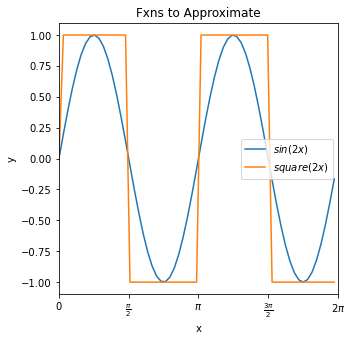

In [2]:
def data_generation(x):
    # interval = [0, 2*pi]
    sin_data = np.sin(2*x)
    square_data = np.sign(sin_data)
    return sin_data, square_data
def column_vec(data):
    x = np.reshape(data, (-1,1))
    return x

timestep = 0.1
x = np.arange(0, 2*np.pi, timestep)
sin_targets, square_targets = data_generation(x)

plt.figure(figsize=(5,5))
plt.plot(x, sin_targets, label="$sin(2x)$")
plt.plot(x, square_targets, label="$square(2x)$")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim([0,2*np.pi])
plt.title("Fxns to Approximate")
labels = ["0",r"$\frac{\pi}{2}$",r"$\pi$",r"$\frac{3\pi}{2}$",r"$2\pi$"]
plt.xticks(np.arange(0, 5/2*np.pi, np.pi/2), labels)
plt.legend()

# transform training data into column vectors
x_training =  column_vec(x)
sin_training_targets = column_vec(sin_targets)
square_training_targets = column_vec(square_targets)

# testing data
timestep = 0.05
x_test = np.arange(0, 2*np.pi, timestep)
sin_test_targets, square_test_targets = data_generation(x_test)

x_test =  column_vec(x_test)
sin_test_targets = column_vec(sin_test_targets)
square_test_targets = column_vec(square_test_targets)

Define RBF Network

In [3]:
class RBF_Network:
    def __init__(self, num_nodes, epochs, variances, patterns, targets, hidden_weights, test_patterns, test_targets, cl_number=False, add_noise=False, online_learning=False, eta=0.1):
        self.num_nodes = num_nodes
        self.epochs = epochs
        self.variances = variances
        self.patterns = patterns
        self.targets = targets

        self.online_learning = online_learning
        self.eta = eta

        self.test_patterns = test_patterns
        self.test_targets = test_targets

        # set mu vector for cluster centers
        if cl_number:
            self.k_means_clusters(num_nodes)
        else:
            self.chosen_clusters(num_nodes)
            # self.mu_vector = column_vec(mu_vector)
        
        # self.mu_vector = column_vec(mu_vector)
        self.phi_of_x = np.reshape(np.array(self.mu_vector), (1,-1))
        self.hidden_weights = hidden_weights
        self.total_error = []
        self.f_of_x = []

        if add_noise == True:
            noise = np.reshape(np.random.normal(0,0.1,len(self.patterns)), (-1,1))
            self.patterns = self.patterns + noise

            noise = np.reshape(np.random.normal(0,0.1,len(self.targets)), (-1,1))
            self.targets = self.targets + noise
            
            noise = np.reshape(np.random.normal(0,0.1,len(self.test_patterns)), (-1,1))
            self.test_patterns = self.test_patterns + noise
            
            noise = np.reshape(np.random.normal(0,0.1,len(self.test_targets)), (-1,1))
            self.test_targets = self.test_targets + noise

    def train_network(self):
        """ For ea epoch, go through ea sample, which passes through each node to produce an output. """
        for e in range(0, self.epochs):
            for x in self.patterns:
                output = []
                for hid_node in range(0, self.num_nodes):
                    # appends output of phi(x) 
                    output.append((self.activation_fxn(self.mu_vector[hid_node], self.variances[hid_node], x))[0])
                output = np.array(output)
                # adds hidden_layer output as row to hidden layer output for other x's
                self.phi_of_x = np.vstack((self.phi_of_x,output))

            # calc f, the output for each sample and store in vector of all outputs
            self.f_of_x= np.dot(self.phi_of_x[1:], self.hidden_weights)

            # calc error per epoch
            self.calc_total_error()
            # print("The error of epoch ", e, ": ", self.total_error[e])

            # update the output weights
            self.update_output_weights()

            # reset phi output
            self.phi_of_x = np.reshape(self.mu_vector, (1,-1))
        

    def activation_fxn(self, position, variance, x):
        return np.exp( ((-(x-position)**2)) / (2*(variance**2)) )

    def calc_total_error(self):
        self.total_error.append( (sum((self.f_of_x-self.targets)**2))[0] )

    def update_output_weights(self):
        self.hidden_weights = np.dot(np.linalg.pinv(self.phi_of_x[1:]), self.targets)
    
    def k_means_clusters(self, number_of_centers):
        # random num for cluster centers from patterns
        centers_indecies = np.random.choice(len(self.patterns), size=number_of_centers, replace=False)
        cluster_distances = []
        for x in centers_indecies:
            # use np.random.shuffle(self.patterns[x])
            cluster_distances.append(self.patterns[x])

        cluster_distances = np.reshape(cluster_distances, (1,-1))
        data_distances = np.reshape(self.patterns, (-1,1))

        # distance between pattern and cluster center
        distances = (data_distances - cluster_distances)**2 

        # assigns smallest distance index (starting from 0) to row, thus assigning sample to cluster  
        cl_assignment = distances.argmin(axis=1)

        self.mu_vector = []
        # loop through each cluster to perform update
        for c in range(0, number_of_centers):
            summation = 0
            number = 0
            # loop through each assignment to check if in cluster
            for i in range(0, len(cl_assignment)):
                # if in cluster, the cluster needs to be moved
                if int(cl_assignment[i]) == int(c): 
                    summation += ((self.patterns[i])**2)**0.5
                    number += 1

            # reassign cluster centers
            if number == 0:
                number += 1
            self.mu_vector.append((summation/number)[0])
         
        # print("Cluster Centers: ", self.mu_vector)
    
    def chosen_clusters(self, num_nodes):
        self.mu_vector = np.arange(0,2*np.pi,2*np.pi/num_nodes)

    def validate(self, _plot=False):
        output = self.validation_output()

        if _plot == True:
            plt.figure(figsize=(5,5))
            plt.plot(self.test_patterns, output, label="Approximation")
            plt.plot(self.test_patterns, self.test_targets, label="Original")
            plt.xlabel("x")
            plt.ylabel("y")
            # plt.xlim([0,2*np.pi])
            plt.title("Outputs when number of RBF nodes = %i" % self.num_nodes)
            # labels = ["0",r"$\frac{\pi}{2}$",r"$\pi$",r"$\frac{3\pi}{2}$",r"$2\pi$"]
            # plt.xticks(np.arange(0, 5/2*np.pi, np.pi/2), labels)
            plt.legend()

        # return (sum((output-self.test_targets)**2))[0]
        return np.mean(np.abs(output-self.test_targets)) 


    def validation_output(self):

        for x in self.test_patterns:
            output = []
            for hid_node in range(0, self.num_nodes):
                # appends output of phi(x) 
                output.append((self.activation_fxn(self.mu_vector[hid_node], self.variances[hid_node], x))[0])
            output = np.array(output)
            # adds hidden_layer output as row to hidden layer output for other x's
            self.phi_of_x = np.vstack((self.phi_of_x,output))

        # calc f, the output for each sample and store in vector of all outputs
        self.f_of_x = np.dot(self.phi_of_x[1:], self.hidden_weights)
        
        # reset phi output  
        self.phi_of_x = np.reshape(self.mu_vector, (1,-1))

        return self.f_of_x
    


One test at 10 nodes for sign

In [4]:
num_nodes = 10
epochs = 100
# must always be as many as there are hidden nodes
variances = [1]*num_nodes
hidden_weights = [0.1]*num_nodes
cl_number = False

patterns = x_training
targets = sin_training_targets

test_patterns = x_test 
test_targets = sin_test_targets 

# targets = square_targets
rbf_network = RBF_Network(num_nodes, epochs, variances, patterns, targets, hidden_weights, test_patterns, test_targets, cl_number)
rbf_network.train_network()
e1 = rbf_network.validate(_plot=False)

### Test Nodes vs Sin RBF, no noise and chosen RBF cluster centers

0.5735941570701878
0.5731342454593259
0.5132534682418769
0.5369721546683682
Node:  5  results in 0.1 error.
0.09024832249508634
Node:  6  results in 0.1 error.
0.08887194418462975
Node:  7  results in 0.1 error.
0.07708133450755217
Node:  8  results in 0.1 error.
0.03679653652367166
Node:  9  results in 0.1 error.
0.021670997526747632
Node:  10  results in 0.01 error.
0.008242114222338502
Node:  11  results in 0.01 error.
0.00358169988964579
Node:  12  results in 0.01 error.
0.0011785375402218283
Node:  13  results in 0.001 error.
0.0003027433997490314
Node:  14  results in 0.001 error.
9.980399703909948e-05
Node:  15  results in 0.001 error.
2.1566303469606015e-05


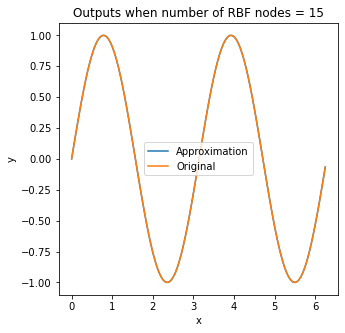

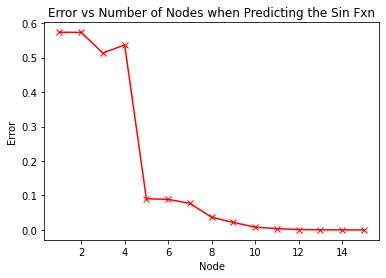

In [5]:
num_nodes_lst = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
error = []

epochs = 100
# must always be as many as there are hidden nodes
variances = [0.1]*num_nodes
hidden_weights = [0.1]*num_nodes
cl_number = False

patterns = x_training
targets = sin_training_targets

test_patterns = x_test 
test_targets = sin_test_targets 

for n in num_nodes_lst:
    num_nodes = n
    epochs = 100
    # must always be as many as there are hidden nodes
    variances = [1]*num_nodes
    hidden_weights = [0.1]*num_nodes

    rbf_network = RBF_Network(num_nodes, epochs, variances, patterns, targets, hidden_weights, test_patterns, test_targets, cl_number)
    rbf_network.train_network()

    if n == num_nodes_lst[-1]:
        error_ = rbf_network.validate(_plot=True)
        error.append(error_)
    else:
        error_ = rbf_network.validate(_plot=False)
        error.append(error_)
    
    if error_ < 0.001:
        print("Node: ", n, " results in 0.001 error.")
    elif error_ < 0.01:
        print("Node: ", n, " results in 0.01 error.")
    elif error_ < 0.1:
        print("Node: ", n, " results in 0.1 error.") 
    
    print(error_)

plt.figure()
plt.plot(num_nodes_lst, error, color='red', marker='x')
plt.xlabel("Node")
plt.ylabel("Error")
plt.title("Error vs Number of Nodes when Predicting the Sin Fxn")
plt.show()

### Test Nodes for Square RBF, no noise and chosen RBF cluster centers

0.2960971523835053
0.2946488115742631
0.2155841068480864
0.1738151784927126
0.1752588332645477
0.1793935261075459
0.17845226469494047


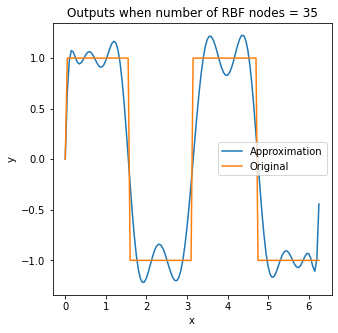

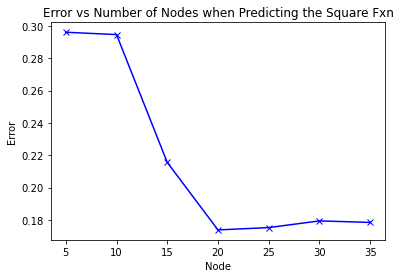

In [6]:
num_nodes_lst = [5,10,15,20,25, 30, 35] 
# num_nodes_lst = [30,35,40,45,50]
error = []

epochs = 150
# must always be as many as there are hidden nodes
variances = [0.1]*num_nodes
hidden_weights = [0.1]*num_nodes
cl_number = False

patterns = x_training
targets = square_training_targets

test_patterns = x_test 
test_targets = square_test_targets 

for n in num_nodes_lst:
    num_nodes = n
    epochs = 100
    # must always be as many as there are hidden nodes
    variances = [1]*num_nodes
    hidden_weights = [0.1]*num_nodes

    rbf_network = RBF_Network(num_nodes, epochs, variances, patterns, targets, hidden_weights, test_patterns, test_targets, cl_number)
    rbf_network.train_network()

    if n == num_nodes_lst[-1]:
        error_ = rbf_network.validate(_plot=True)
        error.append(error_)
    else:
        error_ = rbf_network.validate(_plot=False)
        error.append(error_)
    
    if error_ < 0.001:
        print("Node: ", n, " results in 0.001 error.")
    elif error_ < 0.01:
        print("Node: ", n, " results in 0.01 error.")
    elif error_ < 0.1:
        print("Node: ", n, " results in 0.1 error.") 

    print(error_)

# plt.figure(figsize=(5,5))
plt.figure()
plt.plot(num_nodes_lst, error, color='blue', marker='x')
plt.xlabel("Node")
plt.ylabel("Error")
plt.title("Error vs Number of Nodes when Predicting the Square Fxn")
plt.show()

## 3.2 Regression with noise

Add gaussion noise to the data from above. Mean = 0, variance = 0.1.

Plots all highest node graphs got fot the different variances.

### Sin RBF with Noise, chosen RBF cluster centers

In [7]:
num_nodes_lst = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
error = []

epochs = 100
# must always be as many as there are hidden nodes
variances_lst = [0.01, 0.05, 0.1, 0.2, 0.5]
hidden_weights = [0.1]*num_nodes
cl_number = False

patterns = x_training
targets = sin_training_targets

test_patterns = x_test 
test_targets = sin_test_targets 

for n in num_nodes_lst:
    num_nodes = n
    for var in variances_lst:
    # must always be as many as there are hidden nodes
        variances = [var]*num_nodes
        hidden_weights = [0.1]*num_nodes

        rbf_network = RBF_Network(num_nodes, epochs, variances, patterns, targets, hidden_weights, test_patterns, test_targets, cl_number, add_noise=True)
        rbf_network.train_network()

        if n == num_nodes_lst[-1]:
            error_ = rbf_network.validate(_plot=False)
            error.append(error_)
        else:
            error_ = rbf_network.validate(_plot=False)
            error.append(error_)
        
        # if error_ < 0.001:
        #     print("Node: ", n, " with var ", var, " results in 0.001 error.")
        # elif error_ < 0.01:
        #     print("Node: ", n, " with var ", var, " results in 0.01 error.")
        # elif error_ < 0.1:
        #     print("Node: ", n, " with var ", var, " results in 0.1 error.") 

        print("Node: ", n, " Var: ", var, " Error: ", error_)


Node:  1  Var:  0.01  Error:  0.6358854943690005
Node:  1  Var:  0.05  Error:  0.6440727323770344
Node:  1  Var:  0.1  Error:  0.6453372738737823
Node:  1  Var:  0.2  Error:  0.6432848231759092
Node:  1  Var:  0.5  Error:  0.606117490434262
Node:  2  Var:  0.01  Error:  512509716690.44464
Node:  2  Var:  0.05  Error:  0.6252081133190558
Node:  2  Var:  0.1  Error:  0.6551818473951719
Node:  2  Var:  0.2  Error:  0.6461984761552122
Node:  2  Var:  0.5  Error:  0.6043658963437808
Node:  3  Var:  0.01  Error:  153958097.75662482
Node:  3  Var:  0.05  Error:  0.7745531474349608
Node:  3  Var:  0.1  Error:  0.5625361505363787
Node:  3  Var:  0.2  Error:  0.5346793495272629
Node:  3  Var:  0.5  Error:  0.470306639530847
Node:  4  Var:  0.01  Error:  5.952756284826518
Node:  4  Var:  0.05  Error:  0.6569674769480096
Node:  4  Var:  0.1  Error:  0.6378723046278645
Node:  4  Var:  0.2  Error:  0.6269174457982072
Node:  4  Var:  0.5  Error:  0.6113581626838542
Node:  5  Var:  0.01  Error:  0.648

### Square RBF with Noise, chosen RBF cluster centers

Node:  1  Var:  0.01  Error:  26280781.89923076
Node:  1  Var:  0.05  Error:  1.005015438371513
Node:  1  Var:  0.1  Error:  0.9924437785725738
Node:  1  Var:  0.2  Error:  0.9813684043988545
Node:  1  Var:  0.5  Error:  0.9950180028911331
Node:  5  Var:  0.01  Error:  328352149784.78534
Node:  5  Var:  0.05  Error:  0.9425270143801034
Node:  5  Var:  0.1  Error:  0.8569668988402501
Node:  5  Var:  0.2  Error:  0.7296955241976475
Node:  5  Var:  0.5  Error:  0.6372371922931626
Node:  10  Var:  0.01  Error:  661924947755.8292
Node:  10  Var:  0.05  Error:  0.9988314241218724
Node:  10  Var:  0.1  Error:  0.6803751825986605
Node:  10  Var:  0.2  Error:  0.4421428971329233
Node:  10  Var:  0.5  Error:  0.35026563416490486
Node:  15  Var:  0.01  Error:  191331622173.52243
Node:  15  Var:  0.05  Error:  0.8195470627394283
Node:  15  Var:  0.1  Error:  0.45487048067455205
Node:  15  Var:  0.2  Error:  0.35693557704474016
Node:  15  Var:  0.5  Error:  0.2531699073783822
Node:  20  Var:  0.01 

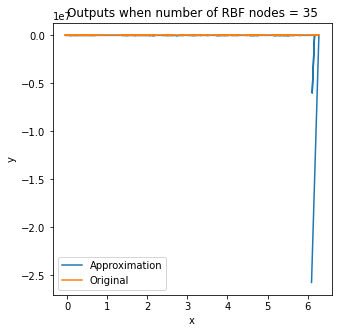

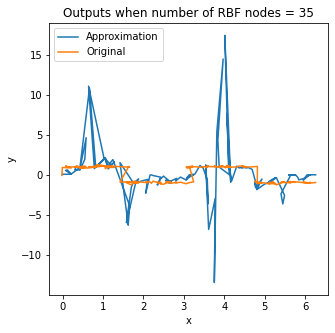

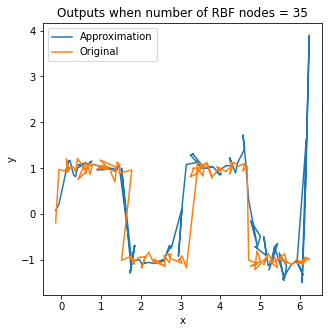

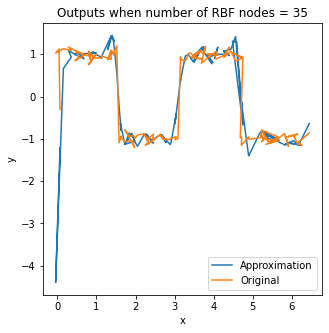

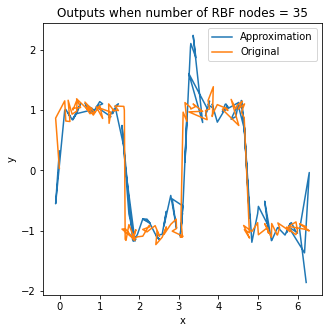

In [8]:
num_nodes_lst = [1,5,10,15,20,25,30,35] 
# num_nodes_lst = [30,35,40,45,50]
error = []

epochs = 100
# must always be as many as there are hidden nodes
variances_lst = [0.01, 0.05, 0.1, 0.2, 0.5]
# variances = [0.5]*num_nodes
hidden_weights = [0.1]*num_nodes
cl_number = True

patterns = x_training
targets = square_training_targets

test_patterns = x_test 
test_targets = square_test_targets 

for n in num_nodes_lst:
    num_nodes = n
    for var in variances_lst:
    # must always be as many as there are hidden nodes
        variances = [var]*num_nodes
        hidden_weights = [0.1]*num_nodes

        rbf_network = RBF_Network(num_nodes, epochs, variances, patterns, targets, hidden_weights, test_patterns, test_targets, cl_number, add_noise=True)
        rbf_network.train_network()

        if n == num_nodes_lst[-1]:
            error_ = rbf_network.validate(_plot=True)
            error.append(error_)
        else:
            error_ = rbf_network.validate(_plot=False)
            error.append(error_)
        
        # if error_ < 0.001:
        #     print("Node: ", n, " with var ", var, " results in 0.001 error.")
        # elif error_ < 0.01:
        #     print("Node: ", n, " with var ", var, " results in 0.01 error.")
        # elif error_ < 0.1:
        #     print("Node: ", n, " with var ", var, " results in 0.1 error.") 

        print("Node: ", n, " Var: ", var, " Error: ", error_)


### Online Delta Rule
- Patterns will be single values going in with single value targets, so no matrix operations. 
- The training network will be sequentially run for each input pattern (loop through samples)
- Set the cl_centers. 

- Note: epochs is not used. online_learning=True. add_noise=True. cl_number=False & manually set (see else). eta must be set. patterns and targets will be scalar.


Delta training network

In [9]:
class RBF_DeltaNetwork:
    def __init__(self, num_nodes, variances, hidden_weights,cl_number=False, eta=0.1):
        self.num_nodes = num_nodes
        self.variances = variances
        self.hidden_weights = np.reshape(hidden_weights, (-1,1))
        self.eta = eta

        self.instantaneous_error = []
        self.all_f_of_x = []

        # set mu vector for cluster centers
        if cl_number:
            self.k_means_clusters(num_nodes)
        else:
            self.chosen_clusters(num_nodes)

        self.validation_output = []

    def train_network(self, pattern, target):
        """ Has single input, and does Delta rule """
        self.pattern = pattern
        self.target = target

        output = []
        for hid_node in range(0, self.num_nodes):
            # appends output of phi(x) 
            output.append((self.activation_fxn(self.mu_vector[hid_node], self.variances[hid_node], self.pattern)))
        # adds hidden_layer output as row to hidden layer output for other x's
        self.phi_of_x = np.reshape(np.array(output), (1,-1))

        # calc f, the output for each sample and store in vector of all outputs
        self.f_of_x= np.dot(self.phi_of_x, self.hidden_weights)

        # calc error per epoch
        self.calc_total_error()
        # print("The error of epoch ", e, ": ", self.total_error[e])

        # update the output weights
        self.update_output_weights()        

    def activation_fxn(self, position, variance, x):
        activation_out = np.exp( ((-(x-position)**2)) / (2*(variance**2)) )
        return activation_out

    def calc_total_error(self):
        self.e = self.target - self.f_of_x
        self.instantaneous_error.append((0.5*((self.e)**2))[0])

    def update_output_weights(self):
        self.hidden_weights += self.eta*self.e*np.reshape(self.phi_of_x, (-1,1))
    
    def k_means_clusters(self, number_of_centers):
        # random num for cluster centers from patterns
        centers_indecies = np.random.choice(len(self.patterns), size=number_of_centers, replace=False)
        cluster_distances = []
        for x in centers_indecies:
            # use np.random.shuffle(self.patterns[x])
            cluster_distances.append(self.patterns[x])

        cluster_distances = np.reshape(cluster_distances, (1,-1))
        data_distances = np.reshape(self.patterns, (-1,1))

        # distance between pattern and cluster center
        distances = (data_distances - cluster_distances)**2 

        # assigns smallest distance index (starting from 0) to row, thus assigning sample to cluster  
        cl_assignment = distances.argmin(axis=1)

        self.mu_vector = []
        # loop through each cluster to perform update
        for c in range(0, number_of_centers):
            summation = 0
            number = 0
            # loop through each assignment to check if in cluster
            for i in range(0, len(cl_assignment)):
                # if in cluster, the cluster needs to be moved
                if int(cl_assignment[i]) == int(c): 
                    summation += ((self.patterns[i])**2)**0.5
                    number += 1

            # reassign cluster centers
            if number == 0:
                number += 1
            self.mu_vector.append((summation/number)[0])
         
        # print("Cluster Centers: ", self.mu_vector)
    
    def chosen_clusters(self, num_nodes):
        self.mu_vector = np.arange(0,2*np.pi,2*np.pi/num_nodes)
    
    def plot_training_instantaneous_error(self):
        plt.figure()
        plt.plot(np.arange(0,len(self.instantaneous_error),1), self.instantaneous_error)
        plt.xlabel("Sample")
        plt.ylabel("Instantaneous Error")
        # plt.xlim([0,2*np.pi])
        plt.title("Instantaneous Error vs sample")
        # labels = ["0",r"$\frac{\pi}{2}$",r"$\pi$",r"$\frac{3\pi}{2}$",r"$2\pi$"]
        # plt.xticks(np.arange(0, 5/2*np.pi, np.pi/2), labels)
        plt.show()

    def validate(self,patterns,targets,_plot=False):
        output = self.validation_of_network(patterns)
        # print(np.shape(output))
        # print(output)
        if _plot == True:
            plt.figure()
            plt.plot(patterns, targets, label="Original")
            plt.plot(patterns, output, label="Approximation", color='orange')
            plt.xlabel("x")
            plt.ylabel("y")
            # plt.xlim([0,2*np.pi])
            plt.title("Approx. with online learning, Delta rule with eta = %f" % self.eta)
            # labels = ["0",r"$\frac{\pi}{2}$",r"$\pi$",r"$\frac{3\pi}{2}$",r"$2\pi$"]
            # plt.xticks(np.arange(0, 5/2*np.pi, np.pi/2), labels)
            plt.legend()
            plt.show()

        # return np.mean(np.abs(output-self.test_targets)) 


    def validation_of_network(self,pattern):
        for p in pattern:
            output = []
            # print(p)
            for hid_node in range(0, self.num_nodes):
                # appends output of phi(x) 
                output.append((self.activation_fxn(self.mu_vector[hid_node], self.variances[hid_node], p)))
            # adds hidden_layer output as row to hidden layer output for other x's
            self.phi_of_x = np.reshape(np.array(output), (1,-1))

            # calc f, the output for each sample and store in vector of all outputs
            self.validation_output.append((np.dot(self.phi_of_x, self.hidden_weights))[0])

        return self.validation_output
            # for hid_node in range(0, self.num_nodes):
            #     # appends output of phi(x) 
            #     output.append((self.activation_fxn(self.mu_vector[hid_node], self.variances[hid_node], self.pattern)))
            # # adds hidden_layer output as row to hidden layer output for other x's
            # self.phi_of_x = np.reshape(np.array(output), (1,-1))

            # # calc f, the output for each sample and store in vector of all outputs
            # self.f_of_x= np.dot(self.phi_of_x, self.hidden_weights)

    
def add_noise(patterns, targets, test_patterns, test_targets):
    noise = np.reshape(np.random.normal(0,0.1,len(patterns)), (-1,1))
    patterns = patterns + noise

    # noise = np.reshape(np.random.normal(0,0.1,len(targets)), (-1,1))
    noise = 0
    targets = targets + noise
    
    noise = np.reshape(np.random.normal(0,0.1,len(test_patterns)), (-1,1))
    test_patterns = test_patterns + noise
    
    # noise = np.reshape(np.random.normal(0,0.1,len(test_targets)), (-1,1))
    noise = 0
    test_targets = test_targets + noise

    return patterns,targets,test_patterns,test_targets

Delta rule algo

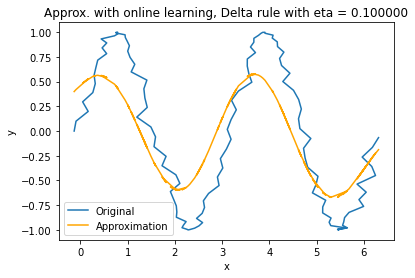

In [10]:
num_nodes = 10

# must always be as many as there are hidden nodes
variances = [0.5]*num_nodes
hidden_weights = [0.1]*num_nodes
eta = 0.1 

patterns,targets,test_patterns,test_targets = add_noise(x_training, sin_training_targets, x_test, sin_test_targets)

# def __init__(self, num_nodes, variances, hidden_weights, cl_number=False, add_noise=False, eta=0.1):
rbf_delta_network = RBF_DeltaNetwork(num_nodes, variances, hidden_weights, cl_number=False, eta=eta)

# loops through the patterns and targets to simulate 'online learning'
for i in range(0, len(patterns)):
    rbf_delta_network.train_network(patterns[i], targets[i])

# rbf_delta_network.plot_training_instantaneous_error()


rbf_delta_network.validate(test_patterns,test_targets, _plot=True)

### Delta rule algo for various eta for Sin
variances between 0.2 and 0.3 are best

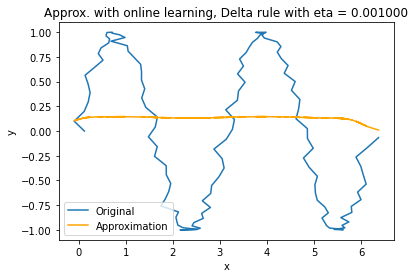

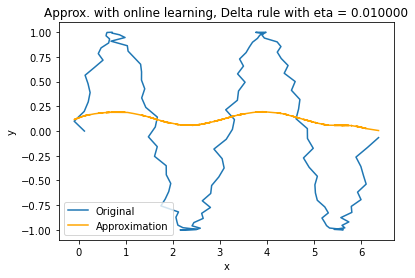

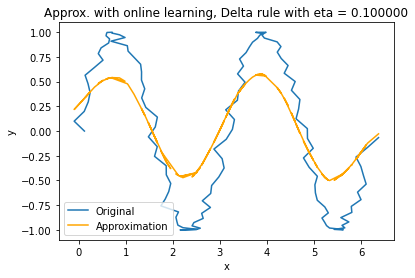

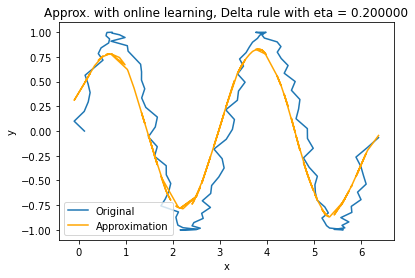

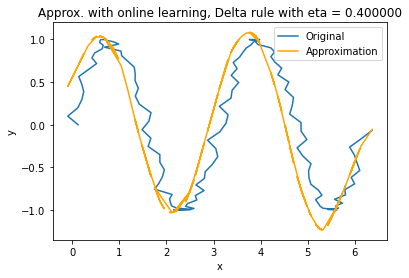

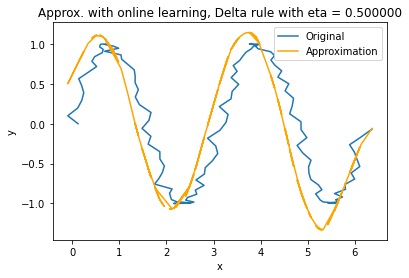

In [11]:
num_nodes = 13

# must always be as many as there are hidden nodes
variances = [0.27]*num_nodes
hidden_weights = [0.1]*num_nodes
eta_lst = [0.001, 0.01, 0.1, 0.2, 0.4, 0.5] 

patterns,targets,test_patterns,test_targets = add_noise(x_training, sin_training_targets, x_test, sin_test_targets)
# patterns,targets,test_patterns,test_targets = x_training, sin_training_targets, x_test, sin_test_targets

for eta in eta_lst:
    rbf_delta_network = RBF_DeltaNetwork(num_nodes, variances, hidden_weights, cl_number=False, eta=eta)

    # loops through the patterns and targets to simulate 'online learning'
    for i in range(0, len(patterns)):
        rbf_delta_network.train_network(patterns[i], targets[i])

    # rbf_delta_network.plot_training_instantaneous_error()

    rbf_delta_network.validate(test_patterns,test_targets, _plot=True)

### Delta rule algo for various eta for Square
variances between 0.2 and 0.3 are best

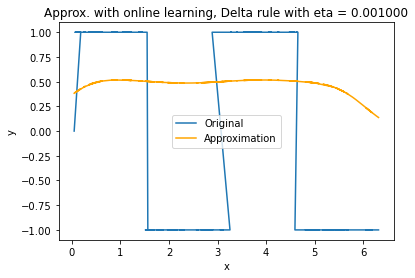

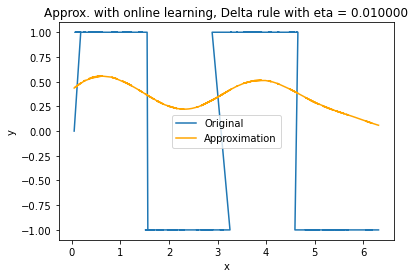

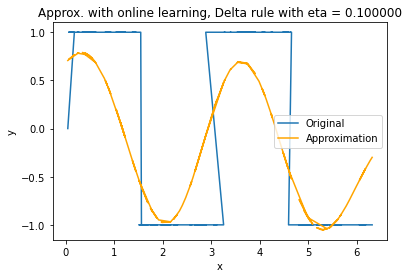

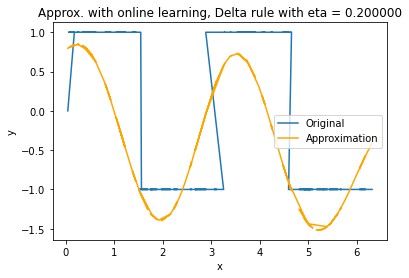

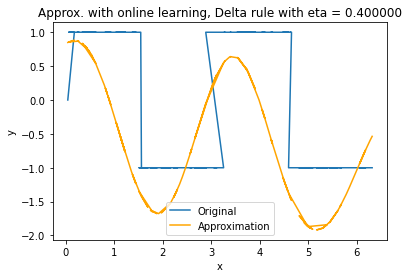

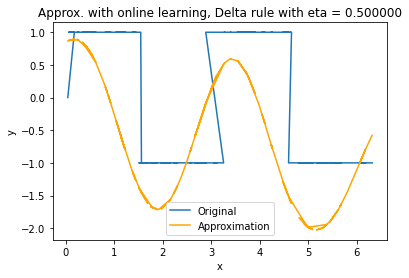

In [12]:
num_nodes = 13

# must always be as many as there are hidden nodes
variances = [0.5]*num_nodes
hidden_weights = [0.2]*num_nodes

eta_lst = [0.001, 0.01, 0.1, 0.2, 0.4, 0.5] 

patterns,targets,test_patterns,test_targets = add_noise(x_training, square_training_targets, x_test, square_test_targets)

# patterns,targets,test_patterns,test_targets = x_training, square_training_targets, x_test, square_test_targets

for eta in eta_lst:
    rbf_delta_network = RBF_DeltaNetwork(num_nodes, variances, hidden_weights, cl_number=False, eta=eta)

    # loops through the patterns and targets to simulate 'online learning'
    for i in range(0, len(patterns)):
        rbf_delta_network.train_network(patterns[i], targets[i])

    # rbf_delta_network.plot_training_instantaneous_error()

    rbf_delta_network.validate(test_patterns,test_targets, _plot=True)

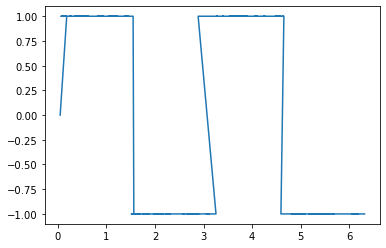

In [13]:
plt.figure()
plt.plot(test_patterns,test_targets)
plt.show()

## 3.3 CL to initialise RBF units
Change cl_number to cl_numer=True to randomly initialise cluster centers and use k-means to position them

### Test Nodes vs Sin RBF, no noise and k-means RBF cluster centers

0.6349506938763768
0.6315649567876656
0.5907538555345382
0.4666264578979155
Node:  5  results in 0.1 error.
0.09201865071448213
0.10542938823386984
Node:  7  results in 0.1 error.
0.08129443357384526
Node:  8  results in 0.1 error.
0.03607132397493806
Node:  9  results in 0.1 error.
0.02241658841354761
Node:  10  results in 0.01 error.
0.007378374482404931
Node:  11  results in 0.01 error.
0.002280280463073509
Node:  12  results in 0.01 error.
0.0031336672785884897
Node:  13  results in 0.001 error.
0.00031251340380040267
Node:  14  results in 0.001 error.
0.0008325634764579678
Node:  15  results in 0.001 error.
0.0004717147523654076


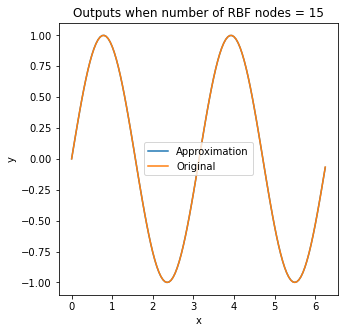

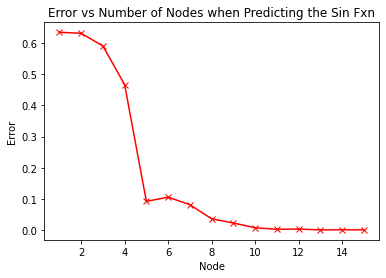

In [14]:
num_nodes_lst = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
error = []

epochs = 100
# must always be as many as there are hidden nodes
# variances = [0.1]*num_nodes
# hidden_weights = [0.1]*num_nodes
cl_number = True

patterns = x_training
targets = sin_training_targets

test_patterns = x_test 
test_targets = sin_test_targets 

for n in num_nodes_lst:
    num_nodes = n
    epochs = 100
    # must always be as many as there are hidden nodes
    variances = [1]*num_nodes
    hidden_weights = [0.1]*num_nodes

    rbf_network = RBF_Network(num_nodes, epochs, variances, patterns, targets, hidden_weights, test_patterns, test_targets, cl_number)
    rbf_network.train_network()

    if n == num_nodes_lst[-1]:
        error_ = rbf_network.validate(_plot=True)
        error.append(error_)
    else:
        error_ = rbf_network.validate(_plot=False)
        error.append(error_)
    
    if error_ < 0.001:
        print("Node: ", n, " results in 0.001 error.")
    elif error_ < 0.01:
        print("Node: ", n, " results in 0.01 error.")
    elif error_ < 0.1:
        print("Node: ", n, " results in 0.1 error.") 
    
    print(error_)

plt.figure()
plt.plot(num_nodes_lst, error, color='red', marker='x')
plt.xlabel("Node")
plt.ylabel("Error")
plt.title("Error vs Number of Nodes when Predicting the Sin Fxn")
plt.show()

### Test Nodes for Square RBF, no noise and k-mean RBF cluster centers

0.632256575555401
0.29519353988417196
0.20021752978902355
0.17676445794483972
0.17509581929161436
0.17499608842153397
0.175178086946881


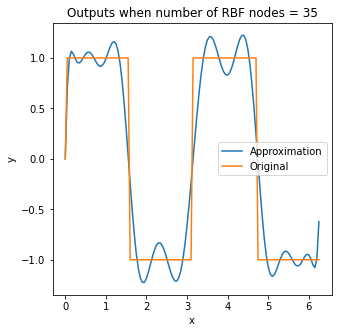

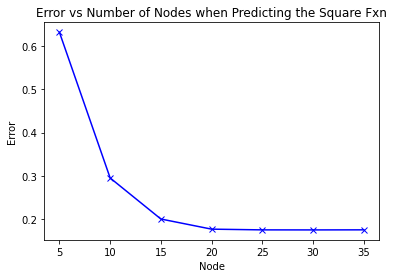

In [15]:
num_nodes_lst = [5,10,15,20,25, 30, 35] 
# num_nodes_lst = [30,35,40,45,50]
error = []

epochs = 150
# must always be as many as there are hidden nodes
variances = [0.1]*num_nodes
hidden_weights = [0.1]*num_nodes
cl_number = True

patterns = x_training
targets = square_training_targets

test_patterns = x_test 
test_targets = square_test_targets 

for n in num_nodes_lst:
    num_nodes = n
    epochs = 100
    # must always be as many as there are hidden nodes
    variances = [1]*num_nodes
    hidden_weights = [0.1]*num_nodes

    rbf_network = RBF_Network(num_nodes, epochs, variances, patterns, targets, hidden_weights, test_patterns, test_targets, cl_number)
    rbf_network.train_network()

    if n == num_nodes_lst[-1]:
        error_ = rbf_network.validate(_plot=True)
        error.append(error_)
    else:
        error_ = rbf_network.validate(_plot=False)
        error.append(error_)
    
    if error_ < 0.001:
        print("Node: ", n, " results in 0.001 error.")
    elif error_ < 0.01:
        print("Node: ", n, " results in 0.01 error.")
    elif error_ < 0.1:
        print("Node: ", n, " results in 0.1 error.") 

    print(error_)

# plt.figure(figsize=(5,5))
plt.figure()
plt.plot(num_nodes_lst, error, color='blue', marker='x')
plt.xlabel("Node")
plt.ylabel("Error")
plt.title("Error vs Number of Nodes when Predicting the Square Fxn")
plt.show()

### Sin RBF with Noise, k-means RBF cluster centers

In [16]:
num_nodes_lst = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
error = []

epochs = 100
# must always be as many as there are hidden nodes
variances_lst = [0.01, 0.05, 0.1, 0.2, 0.5]
hidden_weights = [0.1]*num_nodes
cl_number = True

patterns = x_training
targets = sin_training_targets

test_patterns = x_test 
test_targets = sin_test_targets 

for n in num_nodes_lst:
    num_nodes = n
    for var in variances_lst:
    # must always be as many as there are hidden nodes
        variances = [var]*num_nodes
        hidden_weights = [0.1]*num_nodes

        rbf_network = RBF_Network(num_nodes, epochs, variances, patterns, targets, hidden_weights, test_patterns, test_targets, cl_number, add_noise=True)
        rbf_network.train_network()

        if n == num_nodes_lst[-1]:
            error_ = rbf_network.validate(_plot=False)
            error.append(error_)
        else:
            error_ = rbf_network.validate(_plot=False)
            error.append(error_)
        
        # if error_ < 0.001:
        #     print("Node: ", n, " with var ", var, " results in 0.001 error.")
        # elif error_ < 0.01:
        #     print("Node: ", n, " with var ", var, " results in 0.01 error.")
        # elif error_ < 0.1:
        #     print("Node: ", n, " with var ", var, " results in 0.1 error.") 

        print("Node: ", n, " Var: ", var, " Error: ", error_)

Node:  1  Var:  0.01  Error:  0.6526109809434888
Node:  1  Var:  0.05  Error:  0.6376221942030386
Node:  1  Var:  0.1  Error:  0.6303610100477319
Node:  1  Var:  0.2  Error:  0.64095481733529
Node:  1  Var:  0.5  Error:  0.6385512461097412
Node:  2  Var:  0.01  Error:  1.749233310719177
Node:  2  Var:  0.05  Error:  0.617684747316455
Node:  2  Var:  0.1  Error:  0.5487988614010829
Node:  2  Var:  0.2  Error:  0.5069996626058567
Node:  2  Var:  0.5  Error:  0.5350056269999655
Node:  3  Var:  0.01  Error:  26976384900.35248
Node:  3  Var:  0.05  Error:  0.7026888250219182
Node:  3  Var:  0.1  Error:  0.5718026425049374
Node:  3  Var:  0.2  Error:  0.5635208706193011
Node:  3  Var:  0.5  Error:  0.39235800279418204
Node:  4  Var:  0.01  Error:  44758441.948362984
Node:  4  Var:  0.05  Error:  1.7323775106345713
Node:  4  Var:  0.1  Error:  0.5150469795583755
Node:  4  Var:  0.2  Error:  0.3497251817055194
Node:  4  Var:  0.5  Error:  0.42637521702612396
Node:  5  Var:  0.01  Error:  10537

### Square RBF with Noise, k-means RBF cluster centers

Node:  1  Var:  0.01  Error:  1.3396980819433038
Node:  1  Var:  0.05  Error:  1.0828979328744264
Node:  1  Var:  0.1  Error:  1.000359204274286
Node:  1  Var:  0.2  Error:  0.9906894380286657
Node:  1  Var:  0.5  Error:  0.9933783988108185
Node:  5  Var:  0.01  Error:  6934.105131754196
Node:  5  Var:  0.05  Error:  0.9501406784697962
Node:  5  Var:  0.1  Error:  0.8620320429368582
Node:  5  Var:  0.2  Error:  0.6964776864187974
Node:  5  Var:  0.5  Error:  0.4382984980714952
Node:  10  Var:  0.01  Error:  1223806.0332723584
Node:  10  Var:  0.05  Error:  0.9049833299261473
Node:  10  Var:  0.1  Error:  0.6542240805088806
Node:  10  Var:  0.2  Error:  0.39277101134303155
Node:  10  Var:  0.5  Error:  0.3239978392391262
Node:  15  Var:  0.01  Error:  877578414048.9863
Node:  15  Var:  0.05  Error:  1.1947527285358133
Node:  15  Var:  0.1  Error:  0.4862879726287661
Node:  15  Var:  0.2  Error:  0.3282209935695597
Node:  15  Var:  0.5  Error:  0.277582313817014
Node:  20  Var:  0.01  Er

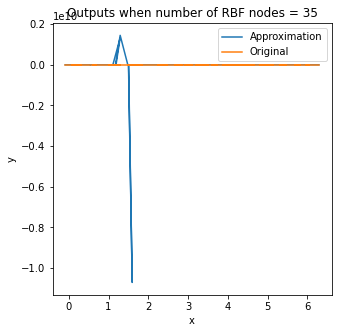

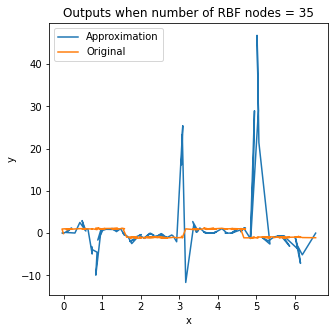

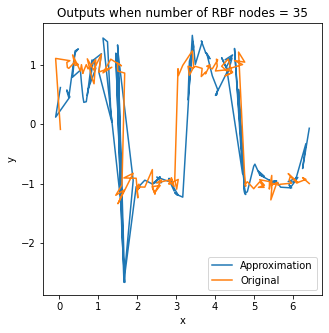

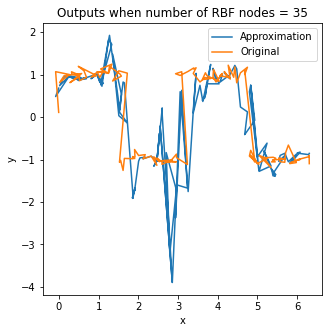

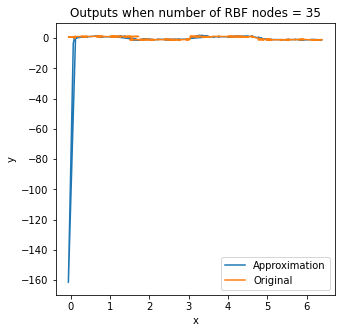

In [17]:
num_nodes_lst = [1,5,10,15,20,25,30,35] 
# num_nodes_lst = [30,35,40,45,50]
error = []

epochs = 100
# must always be as many as there are hidden nodes
variances_lst = [0.01, 0.05, 0.1, 0.2, 0.5]
# variances = [0.5]*num_nodes
hidden_weights = [0.1]*num_nodes
cl_number = True

patterns = x_training
targets = square_training_targets

test_patterns = x_test 
test_targets = square_test_targets 

for n in num_nodes_lst:
    num_nodes = n
    for var in variances_lst:
    # must always be as many as there are hidden nodes
        variances = [var]*num_nodes
        hidden_weights = [0.1]*num_nodes

        rbf_network = RBF_Network(num_nodes, epochs, variances, patterns, targets, hidden_weights, test_patterns, test_targets, cl_number, add_noise=True)
        rbf_network.train_network()

        if n == num_nodes_lst[-1]:
            error_ = rbf_network.validate(_plot=True)
            error.append(error_)
        else:
            error_ = rbf_network.validate(_plot=False)
            error.append(error_)
        
        # if error_ < 0.001:
        #     print("Node: ", n, " with var ", var, " results in 0.001 error.")
        # elif error_ < 0.01:
        #     print("Node: ", n, " with var ", var, " results in 0.01 error.")
        # elif error_ < 0.1:
        #     print("Node: ", n, " with var ", var, " results in 0.1 error.") 

        print("Node: ", n, " Var: ", var, " Error: ", error_)

### RBF with CL for two dimensional function
data generation

In [80]:
f = open('ballist.dat')
# print(f.read())

patterns = np.array([0,0])
targets = np.array([0,0])

animals_data = np.vstack((animals_data,temp))

for line in f:
    # seperate inputs and outputs
    l = line.split('\t')
    # split inputs and convert to float
    ins = l[0].split(' ')
    ins[0] = float(ins[0])
    ins[1] = float(ins[1])

    # split outputs and convert to float
    outs = l[1].replace("\n", "").split(' ')
    outs[0] = float(outs[0])
    outs[1] = float(outs[1])
    
    # stack onto arrays
    patterns = np.vstack((patterns,ins))
    targets = np.vstack((targets,outs))

# remove first initiaisation row
patterns = patterns[1:]
targets = targets[1:]


## 4.1 Topological Ordering of Animal Species
- 32 animals each with 84 binary attributes.
- 32 rows with 84 columns, thus each row contains the attributes of one animal
- Train SOM with one row vector (attributes per animal) at a time  
- 100 output nodes, similar animals classifed close together
- 1D nieghbourhood for the 1D topology
- 100x84 weight mtrx, initialized with random numbers between 0 and 1

use 2 loops, one for 20? epochs, where each epoch goes through all 32 animals. Find row of weight mtrx with shortest distance to the attribute vector. Once the index to wining node is known, update the weights so that they come a little closer using 0.2 as the step size. 

Define the data. Read the data from the file as an array, then split it into vectors with 84 values in each. The top row of the animal data is the atttribute number. 

In [20]:
import numpy as np

In [97]:
with open('animals.dat', 'r') as f:
    l = [[int(num) for num in line.split(',')] for line in f]
# print(l[0])

animal = np.arange(0,32,1)
animals_attribute = np.arange(1,85,1)
animals_data = np.array(animals_attribute)

for a in animal:
    temp = l[0][a*84:((a+1)*84)]
    # print(np.shape(temp))
    animals_data = np.vstack((animals_data,temp))

animals_data = animals_data[1:]


"'antelop'"

In [120]:
class SelfOrganisingMap:
    def __init__(self, patterns, weight_matrix, eta=0.2, neighbour_eta=0.1, epochs=20, alpha=0.2):
        # each row corres to an animal/ class 
        self.patterns = patterns
        self.number_of_classes = np.shape(patterns)[0]
        # each row corres to a node
        self.weight_matrix = weight_matrix      
        self.eta = eta
        self.neighbour_eta = neighbour_eta
        self.epochs = epochs
        self.alpha = alpha

        # used in validation
        self.categories = []
        
    
    def select_animal(self, index):
        """ Selects row and converts to column vector"""
        return np.reshape(self.patterns[index], (-1,1))
    
    def euclidean_distance(self, pattern, node_vector):
        """ Returns absolue euclidean_distance"""
        return abs(np.linalg.norm(pattern-node_vector))

    def min_dist_indecies(self, lst):
        """ Returns index/indecies of minimum distance"""
        prev_minimum = 100000
        all_min_indecies = []

        while True:
            minimum_index = np.argmin(lst)
            if lst[minimum_index] <= prev_minimum:
                all_min_indecies.append(minimum_index)
                prev_minimum = lst[minimum_index]
                lst.pop(minimum_index)
                break
            else:
                break

        return all_min_indecies

    def learn(self):
        """ SOM learning algo. Loops through each class every epoch.
            Updates weights after each class (basically, 32 times per epoch) """

        # Loops through every animal every epoch
        for e in range (0, self.epochs):
            # loops through every animal
            for i in range(0, self.number_of_classes):
                node_output_distances = []
                # column vector of attributes from row vector
                pattern = np.reshape(self.patterns[i], (-1,1))
                # iterate through each node 
                for n in range(0, len(weight_matrix)):
                    node_vector = np.reshape(self.weight_matrix[n], (-1,1))
                    dist = self.euclidean_distance(pattern, node_vector)
                    node_output_distances.append(dist)
                
                # NODE indecies for each animal/class where distance is minimum
                # there can be more than one  
                all_min_indecies = self.min_dist_indecies(node_output_distances)
                
                # selects all the neighbouring indecies, which decreases over time 
                neighbourhood_size = self.select_neighbours(e)
                self.update_weights(pattern, all_min_indecies, neighbourhood_size)

            self.adjust_learning_rate(e)
                

    def update_weights(self, pattern, all_min_indecies, neighbourhood_size):
        """ Updates weights of best matching node and its neighbours 
            proportionally. The indecies correspond to a row in the 
            weight matrix(which is a weight vector for a node)."""
        for x in all_min_indecies:
            # print("Weight", np.shape(self.weight_matrix[x]))
            # print("Pattern", np.shape(pattern))
            # self.weight_matrix[x] += self.eta*(pattern - np.reshape(self.weight_matrix[x])
            self.weight_matrix[x] = self.eta*(np.reshape(pattern, (1,-1)) - np.reshape(self.weight_matrix[x],(1,-1)) )

            upper_bound = x+neighbourhood_size
            if upper_bound > 100:
                upper_bound = 100
            
            lower_bound = x-neighbourhood_size
            if lower_bound < 0:
                lower_bound = 0
            # updates neighbourhood weights
            for xx in range(lower_bound, upper_bound):
                self.weight_matrix[xx] = self.neighbour_eta*(np.reshape(pattern, (1,-1)) - np.reshape(self.weight_matrix[xx],(1,-1)) )
        
    def select_neighbours(self, epoch):
        """ Selects neighbourhood size. The neighbourhood size 
        decreases over time."""
        return round(((self.epochs - epoch)*2.5)/2)

    def adjust_learning_rate(self, e):
        self.eta = self.alpha*(self.eta**(e/self.epochs))
        self.neighbour_eta = self.alpha*(self.neighbour_eta**(e/self.epochs))


    def validate(self):
        # loops through every animal
        for i in range(0, self.number_of_classes):
            node_output_distances = []
            # column vector of attributes from row vector
            pattern = np.reshape(self.patterns[i], (-1,1))
            # iterate through each node 
            for n in range(0, len(weight_matrix)):
                node_vector = np.reshape(self.weight_matrix[n], (-1,1))
                dist = self.euclidean_distance(pattern, node_vector)
                node_output_distances.append(dist)
            
            # NODE indecies for each animal/class where distance is minimum
            # there can be more than one  
            self.categories.append(self.min_dist_indecies(node_output_distances)[0])
            


In [121]:
import numpy as np

# each row has an animal, with 84 columns representing attributes
patterns = animals_data
# 100 rows, 1 per node
weight_matrix = np.random.rand(100, 84)
eta = 0.3
neighbour_eta = 0.1

som_of_animals = SelfOrganisingMap(patterns, weight_matrix, eta=eta, neighbour_eta=neighbour_eta)
som_of_animals.learn()
som_of_animals.validate()

In [122]:
f = open("animalnames.txt", "r")
# print(f.read())
animal_names = [] 
for x in f:
    animal_names.append(x.strip())

animal_dict = {}
for i in range(0, len(som_of_animals.categories)):
    animal_dict[animal_names[i]] = som_of_animals.categories[i]

sort_animals = sorted(animal_dict.items(), key=lambda x: x[1])
for i in sort_animals:
    print(i[0], i[1])

'beetle' 1
'butterfly' 1
'grasshopper' 1
'housefly' 1
'dragonfly' 7
'moskito' 7
'spider' 10
'kangaroo' 17
'skunk' 20
'bear' 22
'hyena' 22
'rat' 27
'rabbit' 30
'bat' 34
'camel' 38
'elephant' 38
'antelop' 40
'seaturtle' 45
'crocodile' 49
'penguin' 54
'pelican' 57
'ostrich' 62
'duck' 63
'cat' 69
'lion' 69
'dog' 75
'frog' 78
'pig' 84
'horse' 87
'giraffe' 91
'walrus' 92
'ape' 99
